## Replicating work by anantgupta129

This is all pretty much directly copied from: https://github.com/anantgupta129/CTU-CHB-Intrapartum-Cardiotocography-Caesarean-Section-Prediction

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

from utils.signal_analysis import plot_power_spectrum, plot_interpolated_df, f, interpolate_df

import os

from collections import Counter
import numpy as np
import seaborn as sns
from imblearn.over_sampling import ADASYN

## Analyse signals using power spectrum to remove noise

The power spectrum results did not show any noise in the data hence to remove the noise interpolation was used. The idea is to use fill the gaps with the interpolation values as we noticed there is no actual noise in the data, we are seeing 0 may due to changing in placement of scope to another position or rotation of the baby or any other value.

In [2]:
df = pd.read_csv('data_csv/1001.csv')
df.head()

,seconds,FHR,UC
0,0,150.50,7.0
1,1,150.50,8.5
2,2,151.00,8.5
3,3,151.25,7.5
4,4,151.25,9.5


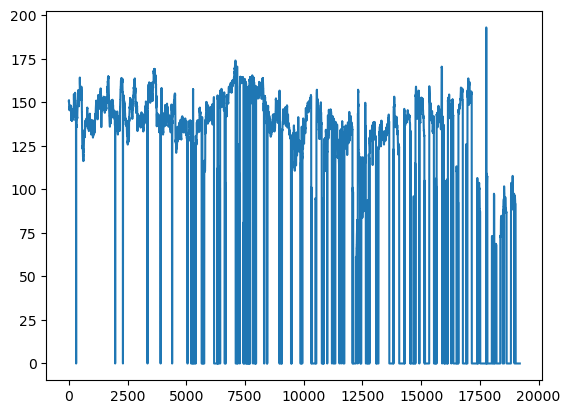

In [3]:
plt.plot(df['seconds'], df['FHR']);

Denoising using Fourier Transform

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


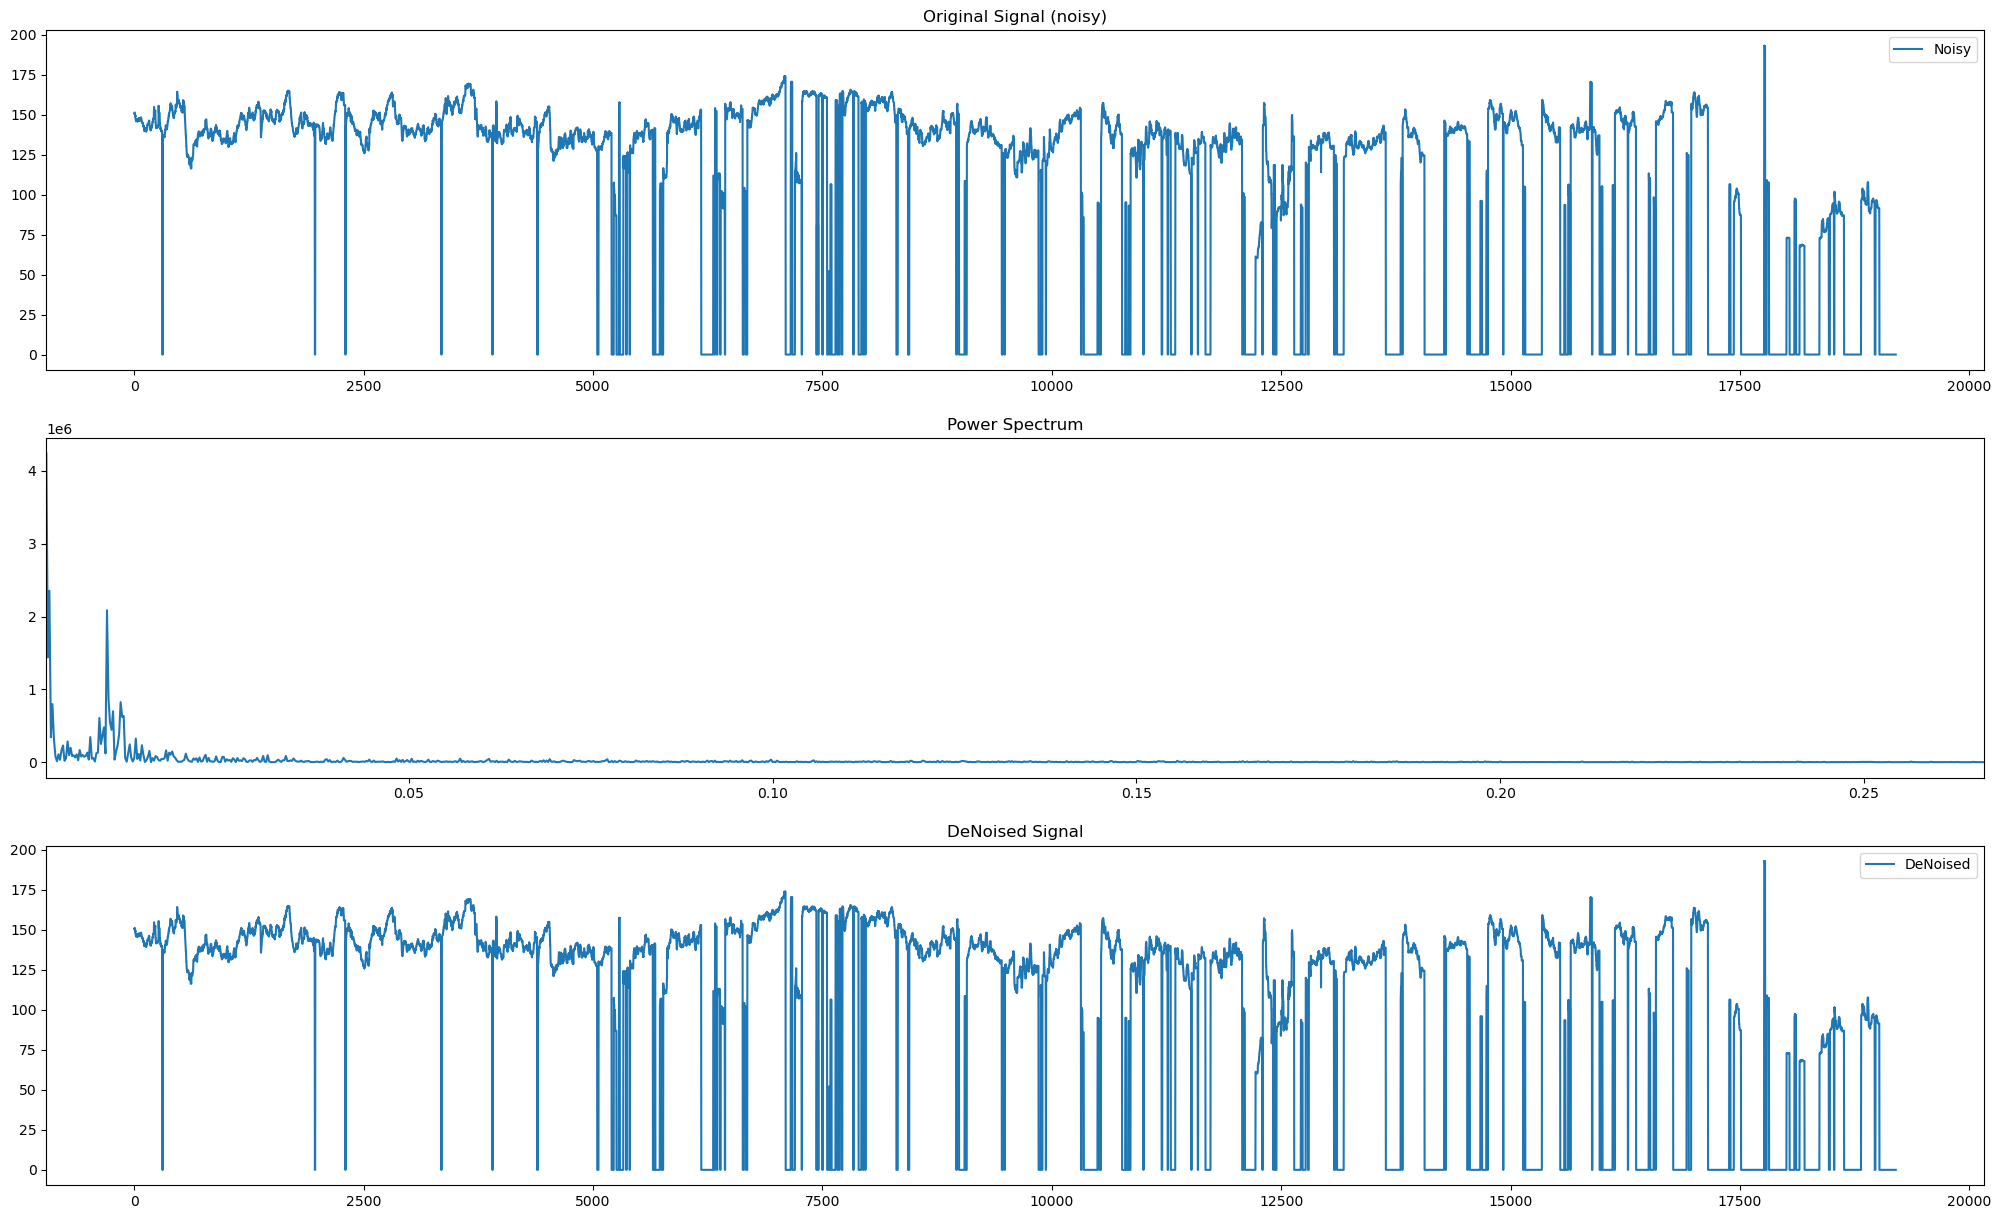

In [4]:
plot_power_spectrum(df, 'FHR')

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


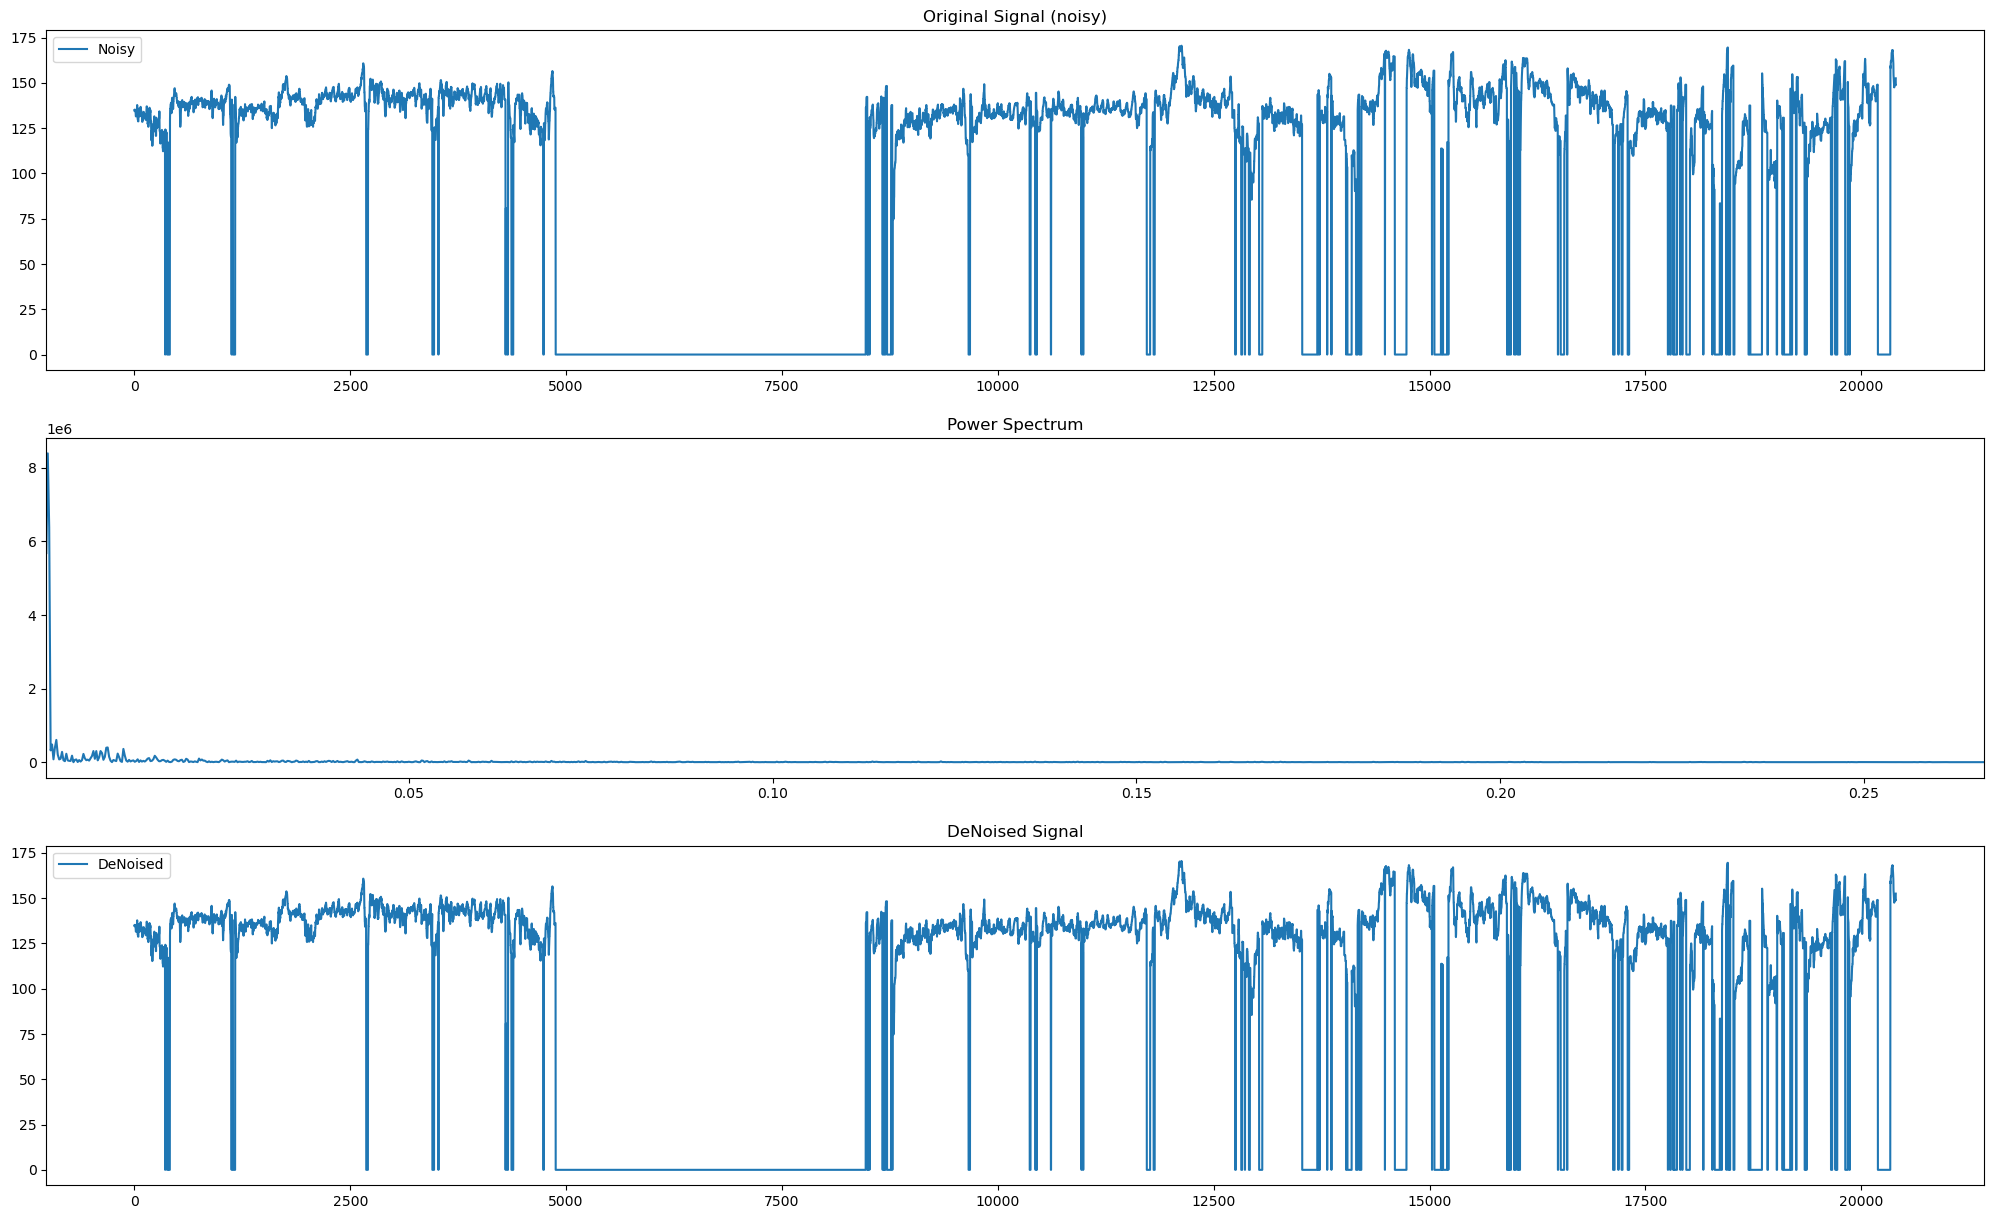

In [5]:
plot_power_spectrum(pd.read_csv('data_csv/1075.csv'), 'FHR')

Denoising using interpolation.

The idea is to use fill the gaps with the interpolation values as we noticed there is no actual noise in the data, we are seeing 0 values may due to changing in placement of scope to another position or rotation of the baby or any other value

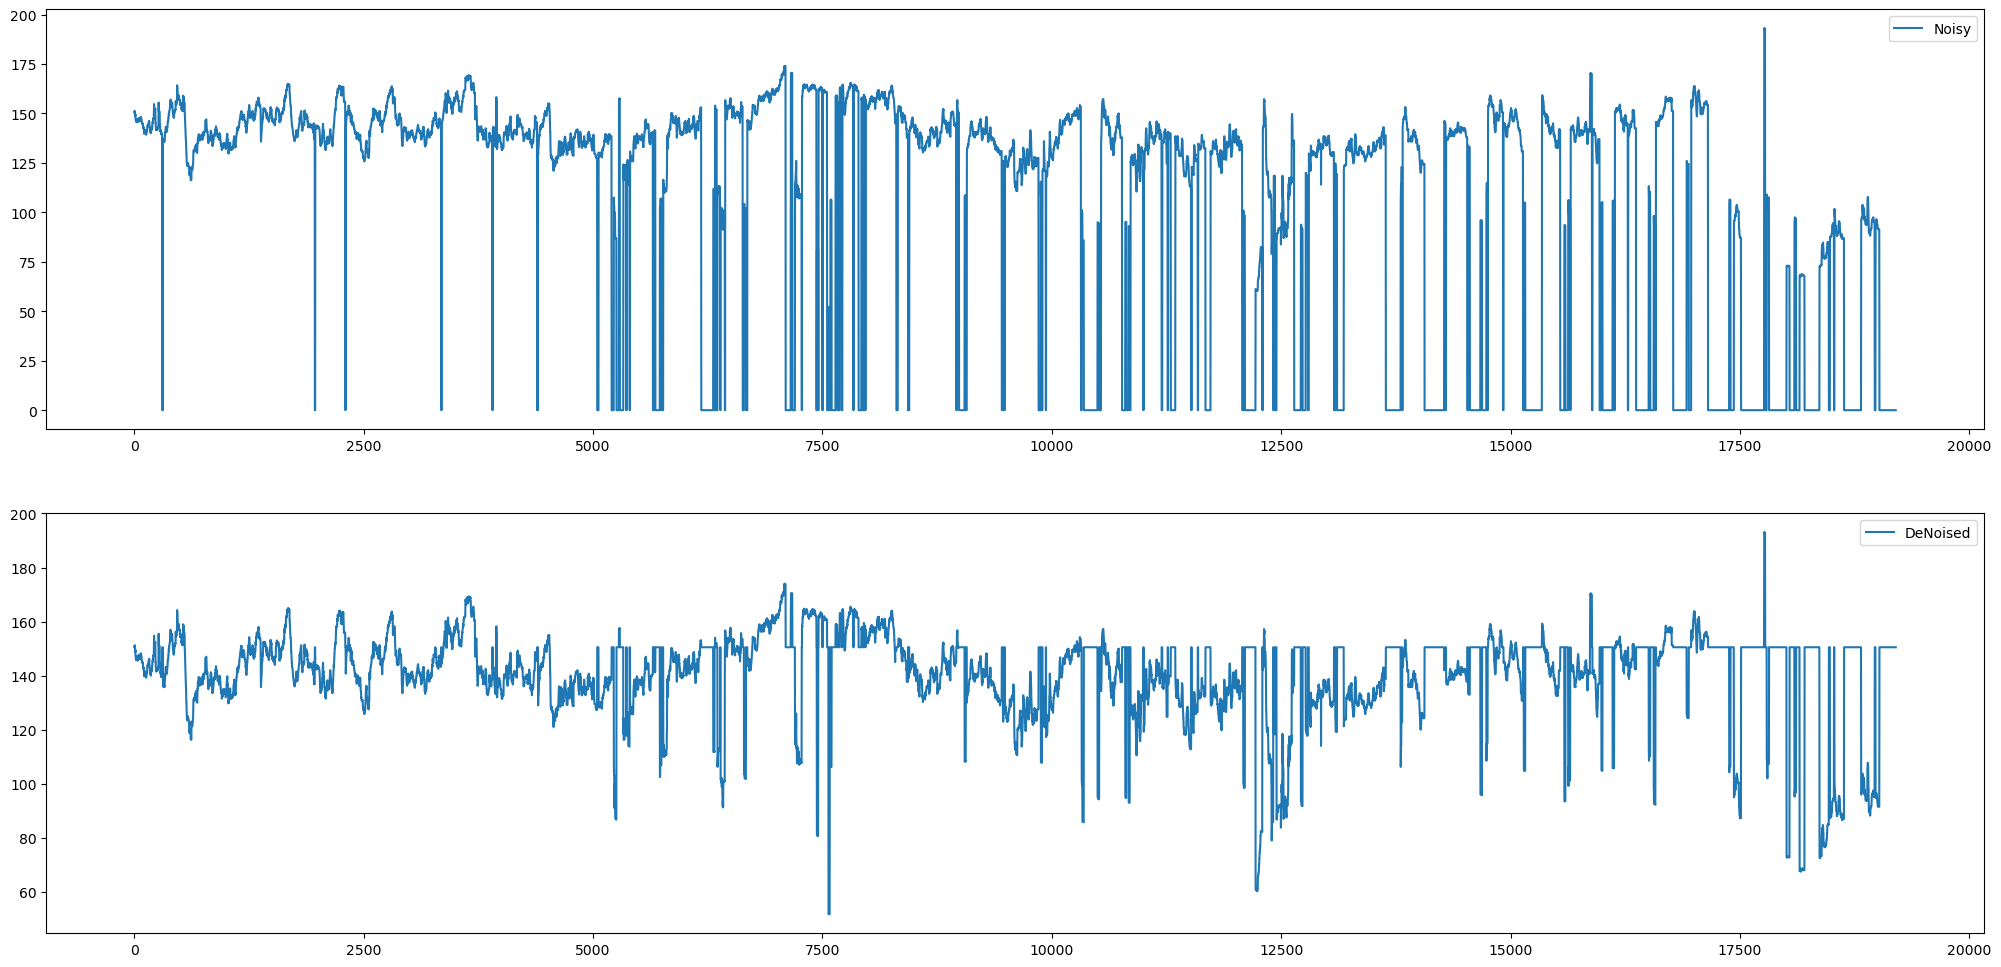

In [6]:
df['FHR_denoised'] = df['FHR'].apply(lambda x: f(df, x) if x<=50 or x>=210 else x)
plot_interpolated_df(df)

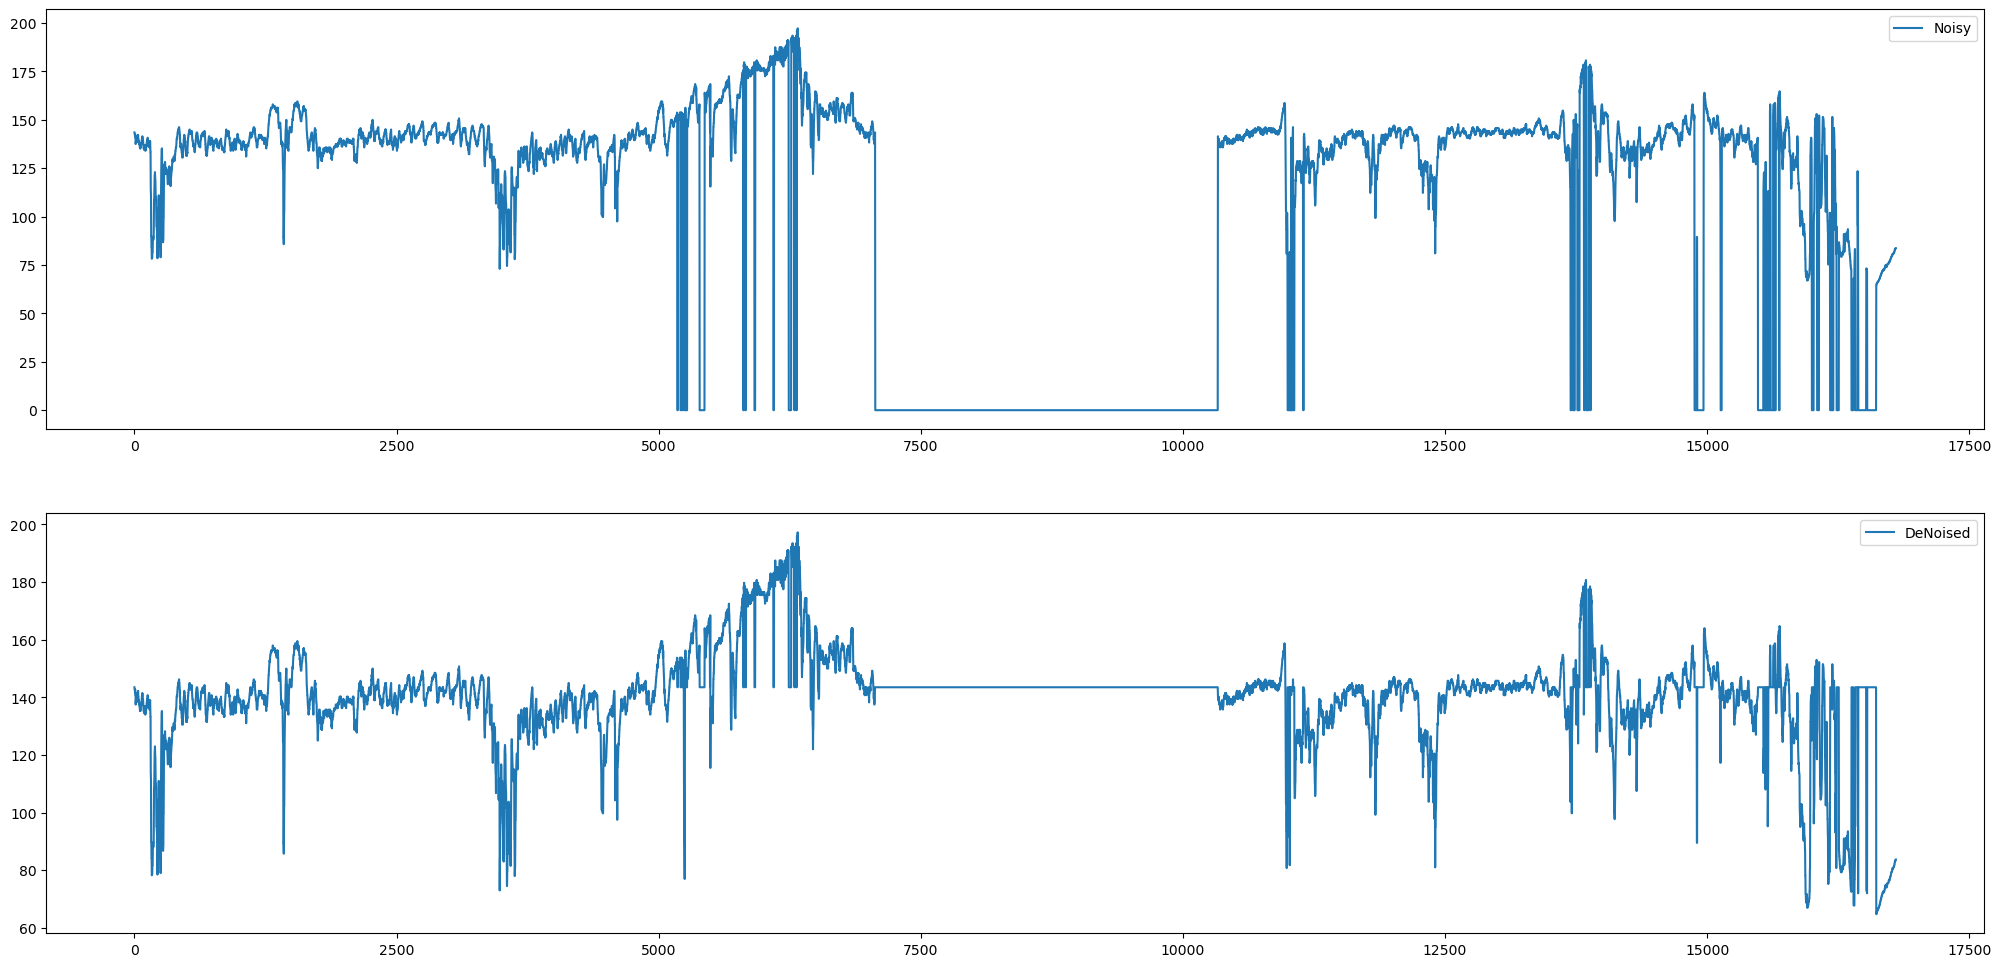

In [8]:
df2 = pd.read_csv(r'data_csv/1006.csv')
df2['FHR_denoised'] = df2['FHR'].apply(lambda x: f(df2, x) if x<=50 or x>=210 else x)
plot_interpolated_df(df2)

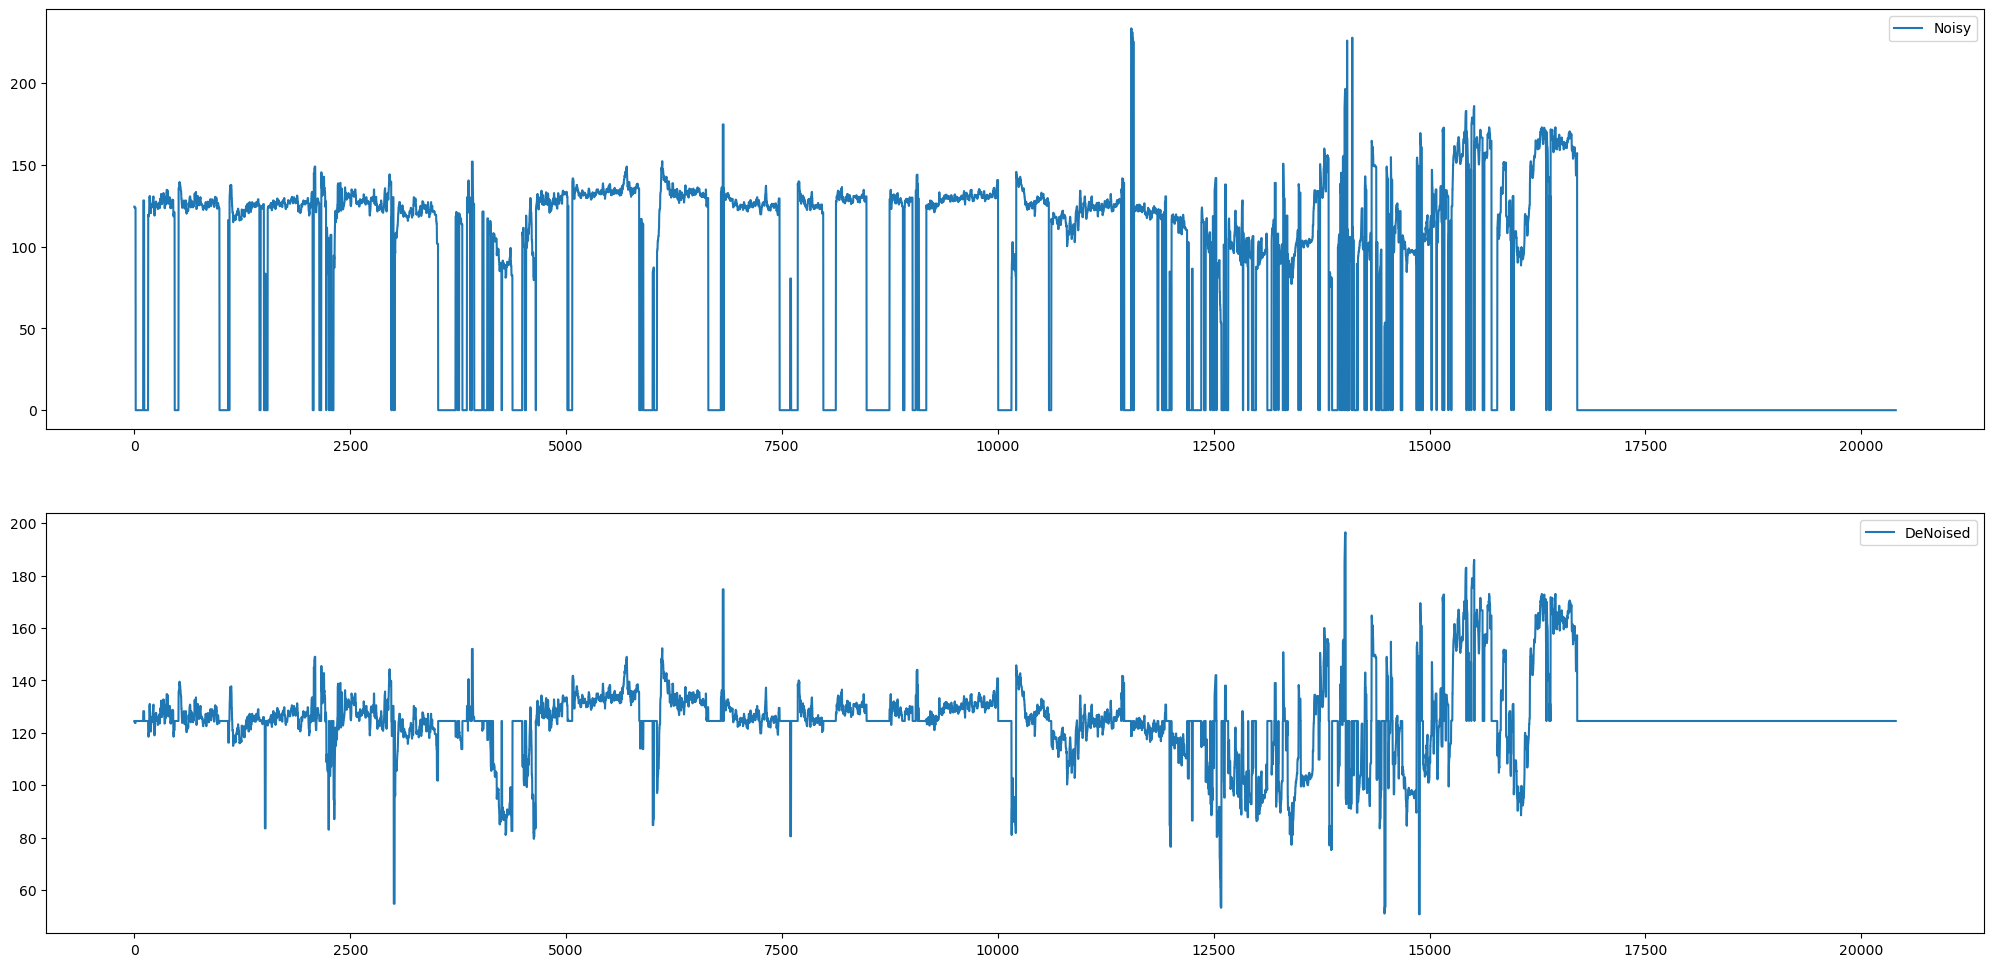

In [9]:
df3 = pd.read_csv(r'data_csv/2043.csv')
df3['FHR_denoised'] = df3['FHR'].apply(lambda x: f(df3, x) if x<=50 or x>=210 else x)
plot_interpolated_df(df3)

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


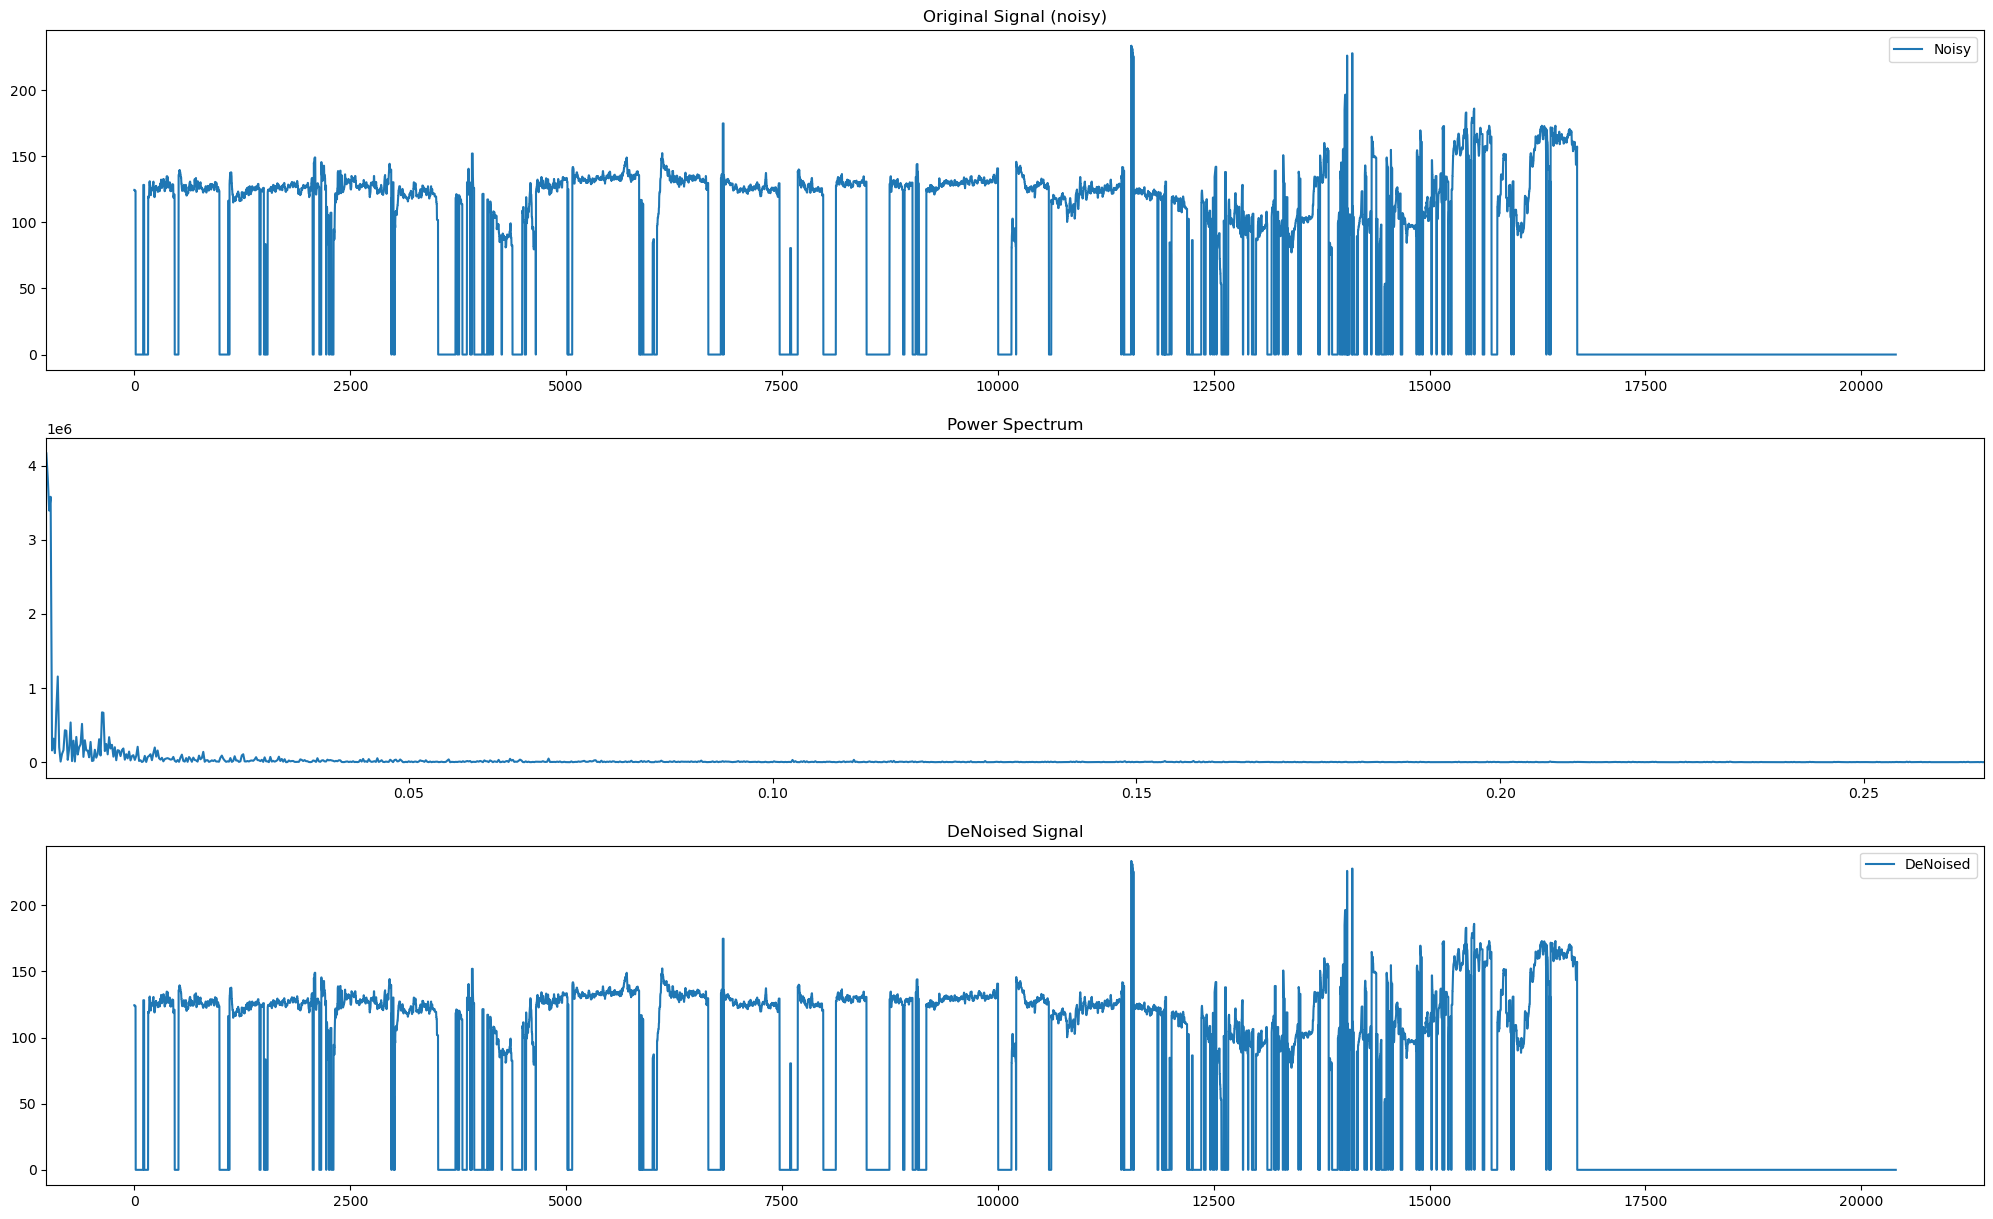

In [10]:
plot_power_spectrum(df3, 'FHR')

## Create interpolated df

Note: Takes apx. 30 minutes to run

In [13]:
root = 'data_csv/'
files = os.listdir(root)

for count, f_name in enumerate(files):
    try:
        path = root + f_name
        df = pd.read_csv(path)
        df = interpolate_df(df, 'FHR')
        patiend_id = f_name.split('.')[0]
        df.to_csv(f'data_signals_interpolated/{patiend_id}.csv', index=False)

        print(f'Saved {f_name}, done {count+1}', end='\r')
    except Exception as e:
        print(e)
        print(f_name)

'FHR' 1504.csv, done 223
metadata.csv


KeyboardInterrupt: 

## Feature extraction

In [ ]:
ann_df = pd.read_csv('data_ann_db/ann_db.csv')
ann_df.sort_values('ID', inplace=True)

for folder in ['data_csv', 'data_signals_interpolated']:
    files = os.listdir(folder)

    mean_f =[]
    median_f = []
    sd_f = []
    peak_f = []
    rms_f = []
    peakto_rms_f = []

    mean_u =[]
    median_u = []
    sd_u = []
    peak_u = []
    rms_u = []
    peakto_rms_u = []

    target = []
    ids = []
    for f in files:
        file_path = os.path.join(path, f)
        df = pd.read_csv(file_path)
        # FHR
        mean_f.append(np.mean(df.FHR_denoised))
        median_f.append(np.median(df.FHR_denoised))
        sd_f.append(np.std(df.FHR_denoised))
        rms_f.append(np.sqrt(np.mean(df.FHR_denoised**2)))
        peak_f.append(np.max(df.FHR_denoised))
        peakto_rms_f.append(np.max(df.FHR_denoised) - np.sqrt(np.mean(df.FHR_denoised**2)))
        # UC
        mean_u.append(np.mean(df.UC))
        median_u.append(np.median(df.UC))
        sd_u.append(np.std(df.UC))
        rms_u.append(np.sqrt(np.mean(df.UC**2)))
        peak_u.append(np.max(df.UC))
        peakto_rms_u.append(np.max(df.UC) - np.sqrt(np.mean(df.UC**2)))
        
        if f[0]=='1':
            target.append(1)
        else:
            target.append(0)
        
        ids.append(int(f.split(".")[0]))

    main_df = pd.DataFrame({
        'Patient_ID':ids,
        'Mean_FHR': mean_f,
        'Mean_UC': mean_u,
        'Median_FHR': median_f,
        'Median_UC': median_u,
        'Std_FHR': sd_f,
        'Std_UC': sd_u,
        'RMS_FHR': rms_f,
        'RMS_UC': rms_u,
        'Peak_to_RMS_FHR': peakto_rms_f,
        'Peak_to_RMS_UC': peakto_rms_u,
        'Peak_FHR': peak_f,
        'Peak_UC': peak_u,
        'target': target,
    })

    main_df.sort_values('Patient_ID', inplace=True)
    final_df = pd.concat([ann_df, main_df], axis=1)

    final_df.drop(['Patient_ID'], axis=1,inplace=True)
    print(final_df.head())
    final_df.to_csv("ctu_df{}.csv".format(folder), index=False)

## Class balancing

In [ ]:
%matplotlib inline

In [ ]:
df = pd.read_csv("ctu_df.csv")
df.head()

In [ ]:
np.any(np.isnan(df))

In [ ]:
np.all(np.isfinite(df))

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


df = clean_dataset(df)


In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

print('Distribution:', Counter(y))
# here we can see that there is huge imbalance in the classes

In [ ]:
ada = ADASYN(sampling_strategy='minority', random_state=420, n_neighbors=5)
X_res, y_res = ada.fit_resample(X, y)

print('Oversampled Target Variable Distribution:', Counter(y_res))
# now the label count is comparable

In [ ]:
feature = pd.DataFrame(X_res, columns=df.columns[:-1])
target = pd.DataFrame(y_res, columns=["target"])

full = pd.concat([feature, target], axis=1)
full

In [ ]:
full.to_csv("ctu_df/final.csv")
# apply same process for inteerpolated df